# Example
"Spectral Analysis for physical applications Multitaper and Cnventional Univariate Techniques", Donald B. Percival and Andrew T. Walden


In [1]:
from scipy.signal import lfilter
import math
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

from mt_harmonic.multitaper import MultiTaper_Periodogram #適宜変更


A unique taper of eigenvalues (>=0.90) was selected. K=7


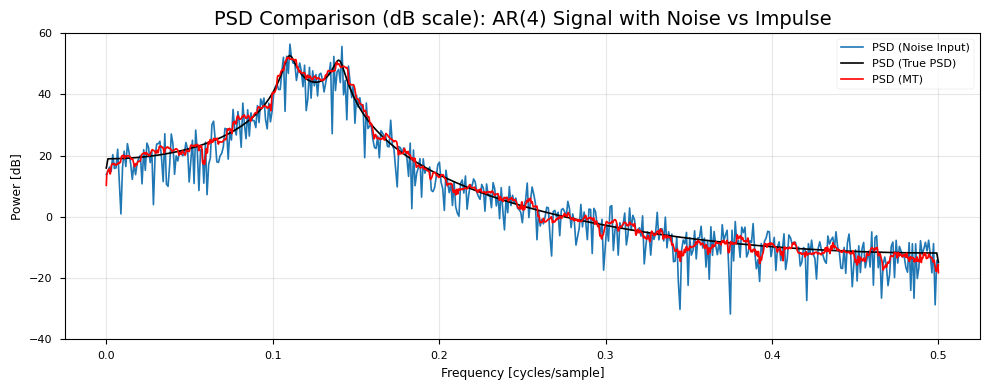

In [9]:
# Generating PSD comparison for AR(4) signal using FFT, Multitaper, and theoretical model
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, windows

# AR(4) coefficients from image
ar_coeffs = np.array([2.7607, -3.8106, 2.6535, -0.9238])
A = np.r_[1, -ar_coeffs]
fs = 1.0
npts = 1024
rng = np.random.default_rng(42)

# Noisy AR signal
sigma = 0.1
c = 20.0
epsilon = rng.normal(0, sigma, npts)
x_noise = lfilter([1.0], A, epsilon) * c

# FFT-based PSD
nfft = 1024
freqs = np.fft.rfftfreq(nfft, d=1/fs)  # 片側周波数軸（0〜fs/2）
X = np.fft.rfft(x_noise, n=nfft)       # 実信号用の片側FFT
psd_noise = (np.abs(X)**2) / (fs * npts)
psd_noise[1:-1] *= 2  # DCとNyquist以外を2倍


# True PSD from AR model
# True PSD from AR model
nfft = 1024
freqs = np.fft.rfftfreq(nfft, d=1/fs)   # 片側周波数軸 (0〜fs/2)
omega = 2*np.pi*freqs

Az = (A[0]
      + A[1]*np.exp(-1j*omega)
      + A[2]*np.exp(-1j*2*omega)
      + A[3]*np.exp(-1j*3*omega)
      + A[4]*np.exp(-1j*4*omega))

var_eff = (sigma**2) * (c**2)
psd_true = var_eff / (np.abs(Az)**2)
psd_true[1:-1] *= 2   # DCとNyquist以外を2倍補正

# FFT-based PSD estimate
X = np.fft.rfft(x_noise, n=nfft)        # 実信号用の片側FFT
psd_noise = (np.abs(X)**2) / (fs * npts)
psd_noise[1:-1] *= 2   # DCとNyquist以外を2倍補正


# マルチターパーPSD推定とF検定
MT_psd = MultiTaper_Periodogram(NW=4, K=8, nfft=2**12)
MT_psd.MT_Spec(x_noise, fs)                 
# MT_psd.Harmonic_Ftest(p_level=0.05)
# print(MT_psd.Smt_k)
# dB変換
psd_noise_db = 10 * np.log10(psd_noise)
Smt_db = 10 * np.log10(MT_psd.Smt)
psd_true_db = 10 * np.log10(psd_true)

# プロット
# Plotting
plt.style.use('seaborn-v0_8-paper')#'mpl20': 'default', 'mpl15': 'classic'
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(freqs, psd_noise_db, label='PSD (Noise Input)',  lw=1.2)
ax.plot(freqs, psd_true_db, label='PSD (True PSD)',c='k',  lw=1.2)
ax.plot(MT_psd.f, Smt_db, label='PSD (MT)',c='r',  lw=1.2)

ax.set_title('PSD Comparison (dB scale): AR(4) Signal with Noise vs Impulse', fontsize=14)
ax.set_xlabel('Frequency [cycles/sample]')
ax.set_ylabel('Power [dB]')
ax.grid(True, alpha=0.3)
ax.set_ylim(-40,60)
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Figure 505. Analysis of Willamette River data, part 1 (a).

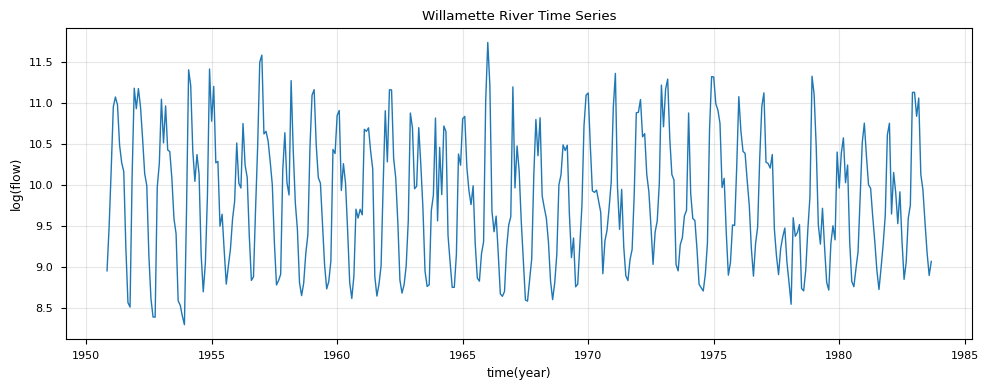

In [3]:
Willamette_data = np.loadtxt("https://faculty.washington.edu/dbp/DATA/Willamette.dat", comments="C")
# サンプル数と時間軸
npts = len(Willamette_data)        # 395
start_year = 1950 + 10/12          # 1950年10月 = 1950 + 10/12 ≈ 1950.83
dt = 1/12                          # 1サンプル = 1ヶ月 = 1/12年
time_axis = start_year + np.arange(npts) * dt
# プロット
plt.style.use('seaborn-v0_8-paper')#'mpl20': 'default', 'mpl15': 'classic'
plt.figure(figsize=(10,4))
plt.plot(time_axis, Willamette_data, lw=1)
plt.title("Willamette River Time Series")
plt.xlabel("time(year)")
plt.ylabel("log(flow)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Figure 512. Analysis of Willamette River data, part 4.

C:\Users\chamu\AppData\Local\Temp\ipykernel_43396\3913735173.py:8: RuntimeWarning: divide by zero encountered in log10
  Re_Smt_db = 10 * np.log10(MT_psd.re_psd)


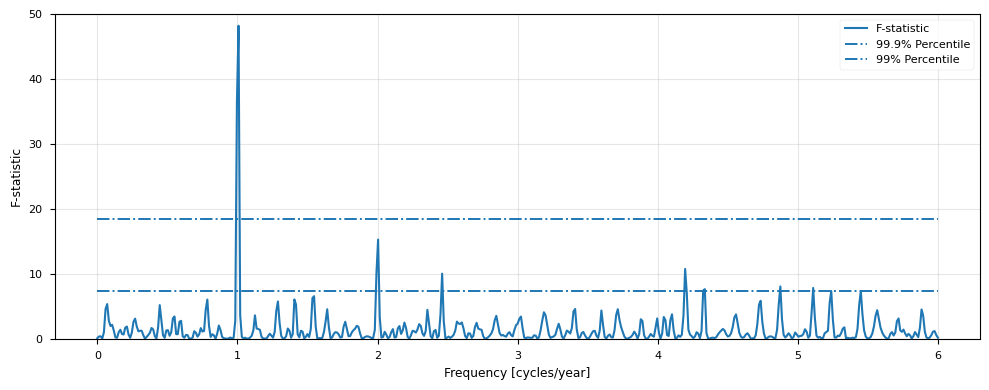

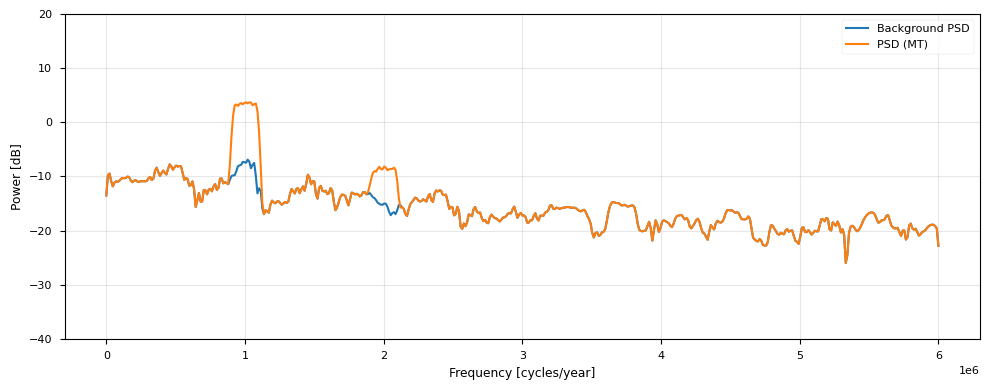

In [4]:
# マルチターパーPSD推定とF検定
MT_psd = MultiTaper_Periodogram(NW=4, K=5, nfft=1024)
MT_psd.MT_Spec(Willamette_data, fs=1/dt)                 
MT_psd.Harmonic_Ftest(p_level=0.005)
# print(MT_psd.Smt_k)
# dB変換
Smt_db = 10 * np.log10(MT_psd.Smt)
Re_Smt_db = 10 * np.log10(MT_psd.re_psd)

# # F統計量のプロット
plt.style.use('seaborn-v0_8-paper')#'mpl20': 'default', 'mpl15': 'classic'
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()
ax.plot(MT_psd.f, MT_psd.F_stat[0, :], '-', label='F-statistic', alpha=1,  lw=1.5)
# ax.hlines(MT_psd.F_crit, MT_psd.f[0], MT_psd.f[-1], linestyles="-.", color='green', label='99.9% Percentile')
ax.hlines(MT_psd.F_999, MT_psd.f[0], MT_psd.f[-1], linestyles="-.", label='99.9% Percentile')
ax.hlines(MT_psd.F_99, MT_psd.f[0], MT_psd.f[-1], linestyles="-.",  label='99% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlabel('Frequency [cycles/year]')
ax.set_ylim(0, 50)
ax.legend()
fig.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

# プロット
plt.style.use('seaborn-v0_8-paper')#'mpl20': 'default', 'mpl15': 'classic'
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(MT_psd.f*1e6, Re_Smt_db[0,:], '-', label='Background PSD', alpha=1,  lw=1.5)
ax.plot(MT_psd.f*1e6, Smt_db, label='PSD (MT)',  lw=1.5)
ax.set_xlabel('Frequency [cycles/year]')
ax.set_ylabel('Power [dB]')
ax.grid(True, alpha=0.3)
ax.set_ylim(-40,20)
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Load sediment core data
Number of points and dt  156 4930


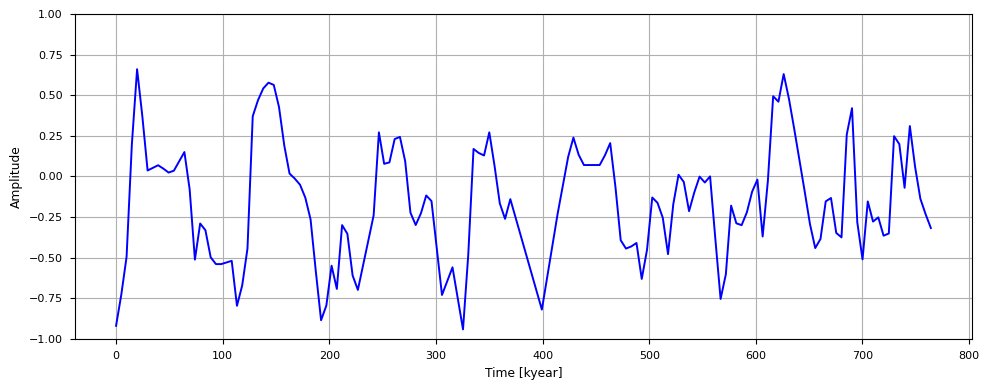

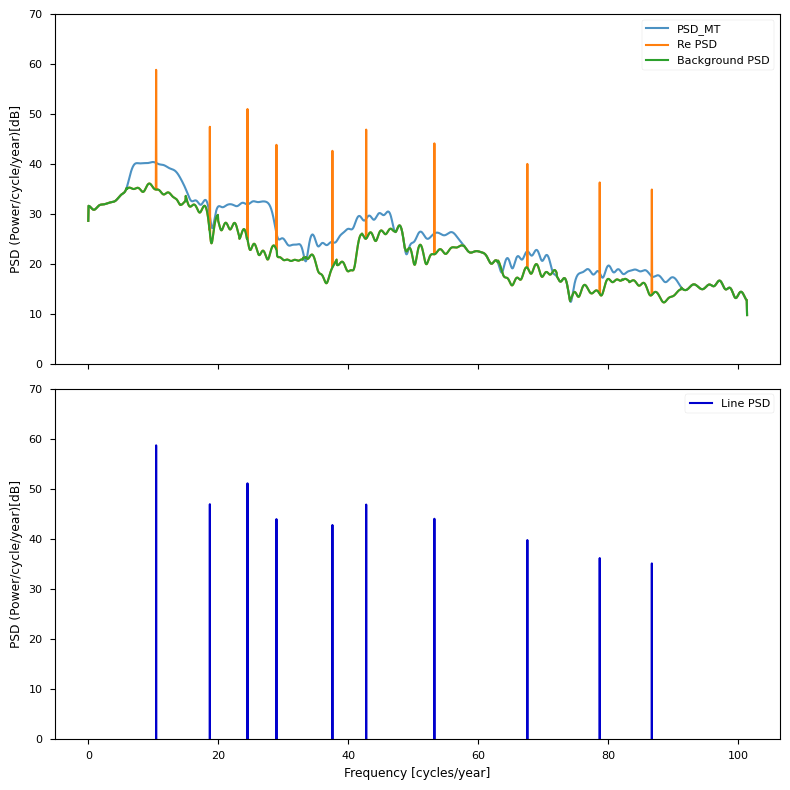

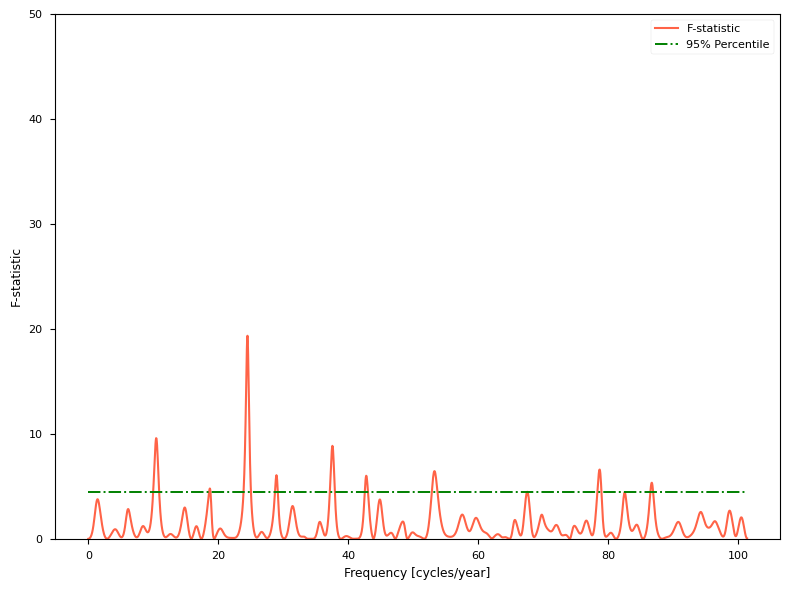

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_data(fname):
   
    if (fname.find("v22")>-1):
        url = 'https://zenodo.org/record/6025794/files/v22_174_series.dat?download=1'
    elif (fname.find("hhe.dat")>-1):
        url = 'https://zenodo.org/record/6025794/files/sgc_vmm_hhe.dat?download=1'
    elif (fname.find("sgc_vmm.dat")>-1):
        url = 'https://zenodo.org/record/6025794/files/sgc_vmm.dat?download=1'
    elif (fname.find("sgc_surf")>-1):
        url = 'https://zenodo.org/record/6025794/files/sgc_surf.dat?download=1'
    elif (fname.find("sgc_mesetas")>-1):
        url = 'https://zenodo.org/record/6025794/files/sgc_mesetas.dat?download=1'
    elif (fname.find("PASC")>-1):
        url = 'https://zenodo.org/record/6025794/files/PASC.dat?download=1'
    elif (fname.find("_src")>-1):
        url = 'https://zenodo.org/record/6025794/files/mesetas_src.dat?download=1'
    elif (fname.find("crisanto")>-1):
        url = 'https://zenodo.org/record/6025794/files/crisanto_mesetas.dat?download=1'
    elif (fname.find("akima")>-1):
        url = 'https://zenodo.org/record/6025794/files/asc_akima.dat?download=1'
    elif (fname.find("ADO")>-1):
        url = 'https://zenodo.org/record/6025794/files/ADO.dat?download=1'
    else:
        data = -1
        
    data = np.loadtxt(url)
    
    return data

# データ読み込みと時間軸生成
x = get_data('v22_174_series.dat')
npts = np.shape(x)[0]
dt   = 4930  # サンプリング間隔 [years]
t    = np.arange(npts) * dt
print('Load sediment core data')
print('Number of points and dt ', npts, dt)

# 元信号のプロット
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()
ax.plot(t / 1e3, x, label="AM Signal", color='b')
ax.set_xlabel("Time [kyear]")   
ax.set_ylabel("Amplitude")
ax.set_ylim(-1.0,1.0)
ax.grid()
plt.tight_layout()
plt.show()

# サンプリング周波数 [cycles/year]
fs = 1.0 / dt

# マルチターパーPSD推定とF検定
MT_psd = MultiTaper_Periodogram(NW=3.5, K=5, nfft=2**12)
MT_psd.MT_Spec(x, fs)                 # ← fs = 1/dt を渡す
MT_psd.Harmonic_Ftest(p_level=0.05)

Smt_db = 10 * np.log10(MT_psd.Smt)
eps = 1e-20
Re_Smt_db = 10 * np.log10(np.maximum(MT_psd.re_psd, eps))

# PSDと再構成スペクトルのプロット
plt.style.use('seaborn-v0_8-paper')#'mpl20': 'default', 'mpl15': 'classic'
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# ① PSD_MTと再構成PSD
ax = axes[0]
ax.plot(MT_psd.f*1e6, Smt_db, '-', label='PSD_MT', alpha=0.8,  lw=1.5)
ax.plot(MT_psd.f*1e6, Re_Smt_db[2, :], '-', label='Re PSD', alpha=1,  lw=1.5)
ax.plot(MT_psd.f*1e6, Re_Smt_db[0, :], '-', label='Background PSD', alpha=1, lw=1.5)

ax.set_ylabel('PSD (Power/cycle/year)[dB]')
# ax.set_xlim(0, 0.1)  # 例: 周波数範囲を cycles/year に合わせて調整
ax.set_ylim(0,70)
ax.legend()

# ③ 線成分スペクトルのみ
ax = axes[1]
ax.plot(MT_psd.f*1e6, Re_Smt_db[1, :], '-', label='Line PSD', alpha=1, c='mediumblue', lw=1.5)
ax.set_ylabel('PSD (Power/cycle/year)[dB]')
ax.set_xlabel('Frequency [cycles/year]')
ax.set_ylim(0,70)
ax.legend()
fig.tight_layout()
plt.show()

# F統計量のプロット
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.plot(MT_psd.f*1e6, MT_psd.F_stat[0, :], '-', label='F-statistic', alpha=1, c='tomato', lw=1.5)
ax.hlines(MT_psd.F_crit, MT_psd.f[0]*1e6, MT_psd.f[-1]*1e6, linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlabel('Frequency [cycles/year]')
# ax.set_xlim(0, 0.1)  # 周波数範囲を cycles/year に合わせて調整
ax.set_ylim(0, 50)
ax.legend()
fig.tight_layout()
plt.show()
